Dataset :\
https://www.kaggle.com/datasets/jangedoo/utkface-new \
Link:\
https://machinelearningmastery.com/keras-functional-api-deep-learning/

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 313M/331M [00:04<00:00, 88.8MB/s]
100% 331M/331M [00:04<00:00, 80.2MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.shape

(23708, 3)

In [ ]:
df.head()

,age,gender,img
0,10,1,10_1_0_20170109204259563.jpg.chip.jpg
1,35,1,35_1_0_20170117174927240.jpg.chip.jpg
2,47,0,47_0_3_20170117190238883.jpg.chip.jpg
3,49,1,49_1_0_20170104184001972.jpg.chip.jpg
4,40,0,40_0_0_20170117182249476.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3708, 3)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [ ]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [ ]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
model.fit(train_generator, batch_size=32, epochs=5, validation_data=test_generator)

Epoch 1/5
625/625 [==============================] - 279s 427ms/step - loss: 103.9198 - age_loss: 15.4203 - gender_loss: 0.8939 - age_mae: 15.4203 - gender_accuracy: 0.5120 - val_loss: 83.3403 - val_age_loss: 14.8165 - val_gender_loss: 0.6922 - val_age_mae: 14.8165 - val_gender_accuracy: 0.5227
Epoch 2/5
625/625 [==============================] - 266s 426ms/step - loss: 83.8574 - age_loss: 15.0177 - gender_loss: 0.6953 - age_mae: 15.0177 - gender_accuracy: 0.5223 - val_loss: 83.2396 - val_age_loss: 14.7207 - val_gender_loss: 0.6921 - val_age_mae: 14.7207 - val_gender_accuracy: 0.5229
Epoch 3/5
625/625 [==============================] - 266s 426ms/step - loss: 83.4554 - age_loss: 14.8475 - gender_loss: 0.6930 - age_mae: 14.8475 - gender_accuracy: 0.5225 - val_loss: 83.7896 - val_age_loss: 15.2674 - val_gender_loss: 0.6921 - val_age_mae: 15.2674 - val_gender_accuracy: 0.5229
Epoch 4/5
625/625 [==============================] - 267s 426ms/step - loss: 83.3419 - age_loss: 14.8069 - gender_

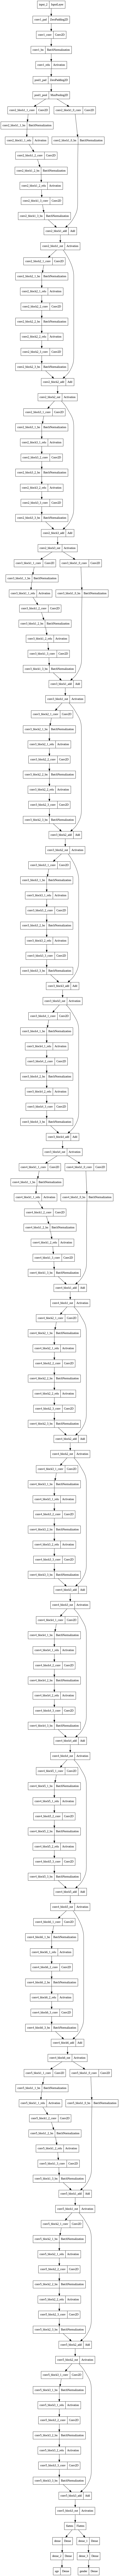

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
test_img = cv2.imread('/content/person.jpg')

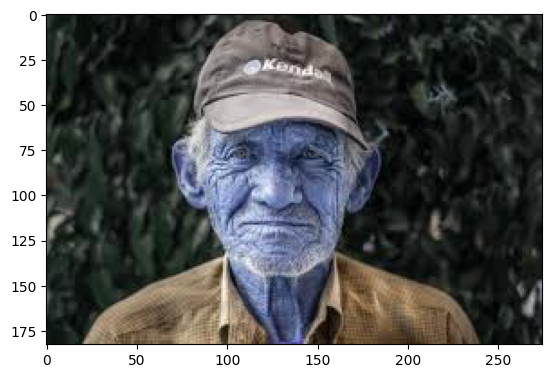

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(183, 275, 3)

In [ ]:
test_img = cv2.resize(test_img,(200,200))

In [ ]:
test_input = test_img.reshape((1,200,200,3))

In [ ]:
model.predict(test_input)

1/1 [==============================] - 3s 3s/step


[array([[11.911736]], dtype=float32), array([[0.32429215]], dtype=float32)]